# **Face Mask Detection**

### **Dataset Import from Kaggle**


In [ ]:
!pip install kaggle

In [ ]:
print("Please upload 'Kaggle.json' file\n\n")
from google.colab import files
files.upload()

Please upload 'Kaggle.json' file




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"san22chit","key":"969ed47ee894517733ee4d5441db718e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 98% 388M/398M [00:02<00:00, 150MB/s]
100% 398M/398M [00:02<00:00, 140MB/s]


In [ ]:
from zipfile import ZipFile
file_name="/content/face-mask-detection.zip"

with ZipFile(file_name,'r')as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('/content/annotations'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/images/maksssksksss409.png
/content/images/maksssksksss479.png
/content/images/maksssksksss476.png
/content/images/maksssksksss517.png
/content/images/maksssksksss746.png
/content/images/maksssksksss30.png
/content/images/maksssksksss791.png
/content/images/maksssksksss385.png
/content/images/maksssksksss299.png
/content/images/maksssksksss84.png
/content/images/maksssksksss65.png
/content/images/maksssksksss31.png
/content/images/maksssksksss244.png
/content/images/maksssksksss575.png
/content/images/maksssksksss460.png
/content/images/maksssksksss155.png
/content/images/maksssksksss193.png
/content/images/maksssksksss242.png
/content/images/maksssksksss29.png
/content/images/maksssksksss293.png
/content/images/maksssksksss26.png
/content/images/maksssksksss840.png
/content/images/maksssksksss256.png
/content/images/maksssksksss789.png
/content/images/maksssksksss440.png
/content/images/maksssksksss246.png
/content/images/maksssksksss592.png
/content/images/maksssksksss41.png

In [ ]:
images_dir = os.path.join('/content/images')
images_name= os.listdir(images_dir)

### **Face and respective Class Extraction**

In [ ]:
from bs4 import BeautifulSoup as XML_extract
import numpy as np
import pandas as pd 
import random as rand
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

def face_location(obj):  
    widthleft = int(obj.find('xmin').text)
    heightlow = int(obj.find('ymin').text)
    widthright = int(obj.find('xmax').text)
    heightup = int(obj.find('ymax').text)    
    return [widthleft, heightlow, widthright, heightup]

In [ ]:
def required(image_id, file): 
    with open(file) as f:
        face_width = []
        labels = []
        data = f.read()
        face_type = XML_extract(data, 'xml')
        face_type_object = face_type.find_all('object')
        num_face_type_objects = len(face_type_object)
        for i in face_type_object:
            flag=2
            face_width.append(face_location(i))
            if i.find('name').text=="with_mask":
              flag=1
            elif i.find('name').text=="without_mask":
              flag=0
            labels.append(flag)
        face_width=np.array(face_width)
        labels=np.array(labels)
        img_id = np.array(image_id)
        target = {}
        target["boxes"] = face_width
        target["labels"] = labels        
        return (target,num_face_type_objects)

In [ ]:
imgs = list(sorted(os.listdir("/content/images")))
len(imgs)

853

In [ ]:
labels = list(sorted(os.listdir("/content/annotations")))

In [ ]:
targets=[]
numobjs=[]
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/content/images/", file_image)
    label_path = os.path.join("/content/annotations/", file_label)
    target,numobj = required(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"../content/images/maksssksksss{}.png".format(i)
    img = cv2.imread(img_path)
    for j in range(numobjs[i]): 
        locs=(targets[i]['boxes'][j])
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (300, 300))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)


In [ ]:
face_labels

array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
face_images.shape

(4072, 300, 300, 3)

In [ ]:
classification=[]
without_mask_array=[1,0,0]
with_mask_array=[0,1,0]
incorrectly_array=[0,0,1]
for i in range(len(face_labels)):
  if face_labels[i]==0:
    classification.append(without_mask_array)
  elif face_labels[i]==1:
    classification.append(with_mask_array)
  elif face_labels[i]==2:
    classification.append(incorrectly_array)

classification=np.array(classification)
classification=np.float32(classification)
classification  

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [ ]:
withmask=[]
withoutmask=[]
incorrect=[]

In [ ]:
for i in range(len(classification)):
  if classification[i][1]==1:
    withmask.append(face_images[i])
  elif classification[i][0]==1:
    withoutmask.append(face_images[i])
  elif classification[i][2]==1:
    incorrect.append(face_images[i])

In [ ]:
num_withmask=len(withmask)
num_withoutmask=len(withoutmask)
num_incorrect=len(incorrect)
Y=[]
Y.append(num_withoutmask)
Y.append(num_withmask)
Y.append(num_incorrect)

In [ ]:
num_withmask


3232

In [ ]:
num_withoutmask


717

In [ ]:
num_incorrect

123

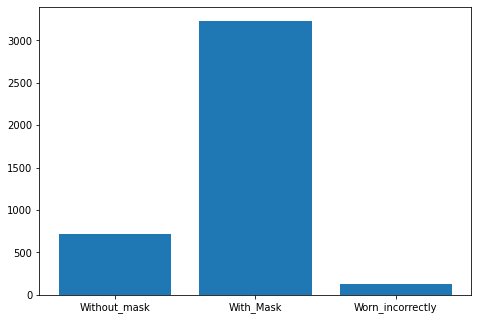

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Without_mask', 'With_Mask', 'Worn_incorrectly']
ax.bar(langs,Y)
plt.show()

### **Model architecture**

In [ ]:
from tensorflow.keras.layers import MaxPooling2D as pooling2x2
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dense as neuron
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D as convulation_layer
from tensorflow.keras.models import Sequential

model = Sequential([
    convulation_layer(16,(3,3),activation='relu',input_shape=(300,300,3)),
    pooling2x2(2,2),

    convulation_layer(32,(3,3),activation='relu'),
    pooling2x2(2,2),

    convulation_layer(64,(3,3),activation='relu'),
    pooling2x2(2,2),

    convulation_layer(64,(3,3),activation='relu'),
    pooling2x2(2,2),

    Flatten(),
    neuron(100,activation='relu'),
    Dropout(0.5),
    neuron(56,activation='relu'),
    neuron(3,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [ ]:
from tensorflow.keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

### **Training of Model and Calculation of Accuracy**



> Split in Train and Test



In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(face_images, classification,
	test_size=0.2, stratify=classification, random_state=42)



> Training of Model


In [ ]:
history = model.fit(
      trainX, trainY, batch_size=32,
	    steps_per_epoch=len(trainX) // 32,
	    validation_data=(testX, testY),
	    validation_steps=len(testX) // 32,
	    epochs=20)

Epoch 1/20
101/101 [==============================] - 6s 58ms/step - loss: 0.9163 - accuracy: 0.7039 - val_loss: 0.6780 - val_accuracy: 0.7950
Epoch 2/20
101/101 [==============================] - 6s 57ms/step - loss: 0.6061 - accuracy: 0.7941 - val_loss: 0.5498 - val_accuracy: 0.7950
Epoch 3/20
101/101 [==============================] - 6s 57ms/step - loss: 0.5445 - accuracy: 0.7944 - val_loss: 0.5226 - val_accuracy: 0.7950
Epoch 4/20
101/101 [==============================] - 6s 57ms/step - loss: 0.5163 - accuracy: 0.7941 - val_loss: 0.5028 - val_accuracy: 0.7950
Epoch 5/20
101/101 [==============================] - 6s 56ms/step - loss: 0.5112 - accuracy: 0.7895 - val_loss: 0.4805 - val_accuracy: 0.7950
Epoch 6/20
101/101 [==============================] - 6s 57ms/step - loss: 0.4752 - accuracy: 0.7997 - val_loss: 0.4653 - val_accuracy: 0.7950
Epoch 7/20
101/101 [==============================] - 6s 56ms/step - loss: 0.4542 - accuracy: 0.7994 - val_loss: 0.4490 - val_accuracy: 0.7950

In [ ]:
history2 = model.fit(
      trainX, trainY, batch_size=32,
	    steps_per_epoch=len(trainX) // 32,
	    validation_data=(testX, testY),
	    validation_steps=len(testX) // 32,
	    epochs=20)

Epoch 1/20
101/101 [==============================] - 6s 58ms/step - loss: 0.2459 - accuracy: 0.9276 - val_loss: 0.2484 - val_accuracy: 0.9275
Epoch 2/20
101/101 [==============================] - 6s 57ms/step - loss: 0.2398 - accuracy: 0.9299 - val_loss: 0.2436 - val_accuracy: 0.9300
Epoch 3/20
101/101 [==============================] - 6s 57ms/step - loss: 0.2335 - accuracy: 0.9296 - val_loss: 0.2389 - val_accuracy: 0.9275
Epoch 4/20
101/101 [==============================] - 6s 57ms/step - loss: 0.2326 - accuracy: 0.9309 - val_loss: 0.2350 - val_accuracy: 0.9275
Epoch 5/20
101/101 [==============================] - 6s 57ms/step - loss: 0.2355 - accuracy: 0.9302 - val_loss: 0.2318 - val_accuracy: 0.9287
Epoch 6/20
101/101 [==============================] - 6s 57ms/step - loss: 0.2270 - accuracy: 0.9358 - val_loss: 0.2307 - val_accuracy: 0.9262
Epoch 7/20
101/101 [==============================] - 6s 58ms/step - loss: 0.2252 - accuracy: 0.9318 - val_loss: 0.2246 - val_accuracy: 0.9250

In [ ]:
model.evaluate(testX,testY)

26/26 [==============================] - 1s 26ms/step - loss: 0.2101 - accuracy: 0.9276


[0.21014969050884247, 0.9276073575019836]

In [ ]:
history.history??

In [ ]:
accuracy=[]

accuracy.append(history.history['accuracy'])
accuracy.append(history2.history['accuracy'])
accuracy=np.array(accuracy)
accuracy=accuracy.flatten()
accuracy

array([0.70389849, 0.79410851, 0.79441863, 0.79410851, 0.78945738,
       0.79968995, 0.79937983, 0.80868214, 0.82418603, 0.85116279,
       0.87069768, 0.88279068, 0.89519382, 0.90573645, 0.91379845,
       0.91534883, 0.92341083, 0.92434108, 0.93023258, 0.92682171,
       0.92759901, 0.92992246, 0.9296124 , 0.93085271, 0.93023258,
       0.93581396, 0.93178296, 0.93395346, 0.93705428, 0.93705428,
       0.93519378, 0.93612403, 0.93705428, 0.93705428, 0.93798447,
       0.93705428, 0.93984497, 0.93798447, 0.9336434 , 0.94201553])

In [ ]:
val_accuracy=[]

val_accuracy.append(history.history['val_accuracy'])
val_accuracy.append(history2.history['val_accuracy'])
val_accuracy=np.array(val_accuracy)
val_accuracy=val_accuracy.flatten()
val_accuracy

array([0.79500002, 0.79500002, 0.79500002, 0.79500002, 0.79500002,
       0.79500002, 0.79500002, 0.79750001, 0.8075    , 0.83875   ,
       0.86250001, 0.88749999, 0.89999998, 0.91125   , 0.91500002,
       0.91374999, 0.91874999, 0.92374998, 0.92624998, 0.92874998,
       0.92750001, 0.93000001, 0.92750001, 0.92750001, 0.92874998,
       0.92624998, 0.92500001, 0.92624998, 0.92750001, 0.92624998,
       0.92624998, 0.93000001, 0.92750001, 0.93000001, 0.92500001,
       0.93124998, 0.92874998, 0.93000001, 0.92874998, 0.93000001])

In [ ]:
loss=[]

loss.append(history.history['loss'])
loss.append(history2.history['loss'])
loss=np.array(loss)
loss=loss.flatten()
loss

array([0.91625249, 0.60606831, 0.54445595, 0.51633555, 0.51122564,
       0.47522449, 0.45419338, 0.43763191, 0.41139209, 0.4047361 ,
       0.36945698, 0.36312571, 0.32980376, 0.32549733, 0.30588967,
       0.29284894, 0.28051791, 0.26257777, 0.25476351, 0.24742104,
       0.24588747, 0.23981167, 0.23351888, 0.23262486, 0.235506  ,
       0.22698382, 0.22516443, 0.21223404, 0.21199822, 0.21950753,
       0.21219534, 0.21892968, 0.2046551 , 0.21273743, 0.20466399,
       0.20524439, 0.20294531, 0.19709486, 0.21425569, 0.19306408])

In [ ]:
val_loss=[]

val_loss.append(history.history['val_loss'])
val_loss.append(history2.history['val_loss'])
val_loss=np.array(val_loss)
val_loss=val_loss.flatten()
val_loss

array([0.67802757, 0.5498054 , 0.52264547, 0.50283992, 0.48054406,
       0.46532777, 0.44903713, 0.43000451, 0.41445968, 0.3934744 ,
       0.37113887, 0.34994817, 0.33463019, 0.31183511, 0.30275103,
       0.28779772, 0.2749716 , 0.26514468, 0.25926057, 0.25584573,
       0.24842367, 0.24359098, 0.23886923, 0.23497576, 0.2318408 ,
       0.23074608, 0.22457738, 0.22479761, 0.22316988, 0.21928644,
       0.21754557, 0.21461444, 0.2132069 , 0.2119997 , 0.210521  ,
       0.21016183, 0.20787592, 0.20624141, 0.20559147, 0.20317569])

<function matplotlib.pyplot.show>

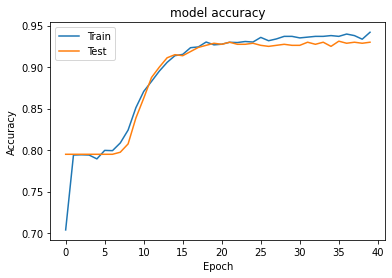

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc="upper left")
plt.show


<function matplotlib.pyplot.show>

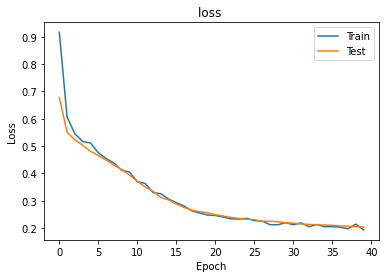

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss)
plt.plot(val_loss)
plt.title('loss ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc="upper right")
plt.show